In [1]:
import numpy as np
import pandas as pd
import datasets
import torch
import transformers
import typing
import requests
import tqdm
import pathlib
import json

import medrag.utils
import medrag.finetune

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
retriever = medrag.utils.RetrievalSystem(corpus_name="Textbooks", db_dir="./corpus")
# finetune = medrag.utils.RetrievalSystem(retriever_name="./cache/medcpt-embedding-model", corpus_name="Textbooks", db_dir="./corpus")

benchmark_df = medrag.finetune.load_benchmark_dataset()

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def load_medqa():
  medqa = datasets.load_dataset("bigbio/med_qa")

  splits = []
  for split_name in medqa.keys():
    split = medqa[split_name]
    split = split.to_pandas()
    split = split.rename(columns={"answer": "answer_text"})
    split = split.rename(columns={"answer_idx": "answer"})

    # replace {'key': 'A', 'value': 'xyz' } in the options column with {'a': 'xyz', ...}
    def replace_keys_with_letters(options):
        return {opt["key"]: opt["value"] for opt in options}

    split["dataset"] = "medqa"
    split["options"] = split["options"].apply(replace_keys_with_letters)
    split["split"] = split_name
    splits.append(split)

  medqa = pd.concat(splits)
  return medqa
  
medqa = load_medqa()
medqa.head(3)

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/datasets/load.py:1491: FutureWarning: The repository for bigbio/med_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bigbio/med_qa
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


,meta_info,question,answer,answer_text,options,dataset,split
0,step2&3,"A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus. Which of the following is the best treatment for this patient?",E,Nitrofurantoin,"{'A': 'Ampicillin', 'B': 'Ceftriaxone', 'C': 'Ciprofloxacin', 'D': 'Doxycycline', 'E': 'Nitrofurantoin'}",medqa,train
1,step2&3,A 3-month-old baby died suddenly at night while asleep. His mother noticed that he had died only after she awoke in the morning. No cause of death was determined based on the autopsy. Which of the following precautions could have prevented the death of the baby?,A,Placing the infant in a supine position on a firm mattress while sleeping,"{'A': 'Placing the infant in a supine position on a firm mattress while sleeping', 'B': 'Routine postnatal electrocardiogram (ECG)', 'C': 'Keeping the infant covered and maintaining a high room temperature', 'D': 'Application of a device to maintain the sleeping position', 'E': 'Avoiding pacifier use during sleep'}",medqa,train
2,step1,"A mother brings her 3-week-old infant to the pediatrician's office because she is concerned about his feeding habits. He was born without complications and has not had any medical problems up until this time. However, for the past 4 days, he has been fussy, is regurgitating all of his feeds, and his vomit is yellow in color. On physical exam, the child's abdomen is minimally distended but no other abnormalities are appreciated. Which of the following embryologic errors could account for this presentation?",A,Abnormal migration of ventral pancreatic bud,"{'A': 'Abnormal migration of ventral pancreatic bud', 'B': 'Complete failure of proximal duodenum to recanalize', 'C': 'Error in neural crest cell migration', 'D': 'Abnormal hypertrophy of the pylorus', 'E': 'Failure of lateral body folds to move ventrally and fuse in the midline'}",medqa,train


In [6]:
# Load Llama in bfloat16 precision
model = transformers.AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16).to("cuda")
tokenizer = transformers.AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", padding_side="left")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
# make a multiple-choice question from a row.
import typing

SYSTEM_PROMPT = (
    "You are a helpful medical expert, and your task is to answer a multi-choice medical question.\n"
    "Your responses will be used for research purposes only, so please have a definite answer.\n"
    "Answer using a only single letter, A, B, C, D, or E. Do not explain further.\n\n"
)

def build_prompt(record: typing.Dict, context: str = ""):
    question = record["question"]
    options = record["options"]
    options = "\n".join(f"{key}: {value}" for key, value in options.items())
    prompt = (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>"
        + SYSTEM_PROMPT
        + "<|eot_id|><|start_header_id|>user<|end_header_id|>"
        + "Here is some useful context for your question: "
        + context
        + f"Question: {question}\n\n"
        + options
        + "\n\nAnswer (A, B, C, D, or E): "
        + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>"
    )
    return prompt

tokens = tokenizer([build_prompt(benchmark_df.iloc[0])], return_tensors="pt").to("cuda")
output = model.generate(
    **tokens,
    max_new_tokens=5,
    output_logits=True,
    return_dict_in_generate=True,
    pad_token_id=tokenizer.eos_token_id,
)
output = tokenizer.decode(output["sequences"][0])
print(output)

<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>You are a helpful medical expert, and your task is to answer a multi-choice medical question.
Your responses will be used for research purposes only, so please have a definite answer.
Answer using a only single letter, A, B, C, D, or E. Do not explain further.

<|eot_id|><|start_header_id|>user<|end_header_id|>Here is some useful context for your question: Question: A junior orthopaedic surgery resident is completing a carpal tunnel repair with the department chairman as the attending physician. During the case, the resident inadvertently cuts a flexor tendon. The tendon is repaired without complication. The attending tells the resident that the patient will do fine, and there is no need to report this minor complication that will not harm the patient, as he does not want to make the patient worry unnecessarily. He tells the resident to leave this complication out of the operative report. Which of the following

In [9]:
# Let's try it out
sample_df = benchmark_df.sample(16, random_state=42)
outputs = batch_predict(model, tokenizer, sample_df.to_dict("records"))
pd.DataFrame(outputs).head(5)

,answer,dataset,question,options,reference,logits,probits,correct
0,A,medmcqa,Dicor is,"{'A': 'Castable ceramic', 'B': 'Metavite', 'C': 'Vitallium', 'D': 'Vita ceramic'}",A,"[34.75, 27.375, 25.75, 29.5, 20.375]","[0.9940376, 0.00062298996, 0.00012267398, 0.0052162306, 5.680933e-07]",True
1,C,medmcqa,"A 42 years old woman from a dry state who ingested rye for long time presented with complaints of weakness in both lower limbs, nausea and fatigue. Over due course of time, she is completely unable to walk. What is the most likely cause?","{'A': 'Argemone mexicana', 'B': 'Amanita', 'C': 'Ergot alkaloids', 'D': 'Lathyrus sativus'}",D,"[29.75, 30.625, 33.5, 28.625, 23.75]","[0.021622984, 0.051870838, 0.91943264, 0.0070199547, 5.3598014e-05]",False
2,B,medqa,"A 4-year-old child is rushed to the emergency department after developing sudden abdominal pain followed by nausea, vomiting, and dark, almost black-colored stool. Prior to the onset of symptoms, he was seen playing with his mother’s purse containing a bottle of vitamin supplements, which she takes for chronic microcytic anemia. Which of the following medications is the treatment for this patient's intoxication?","{'A': 'Dimercaprol', 'B': 'Deferoxamine', 'C': 'Protamine', 'D': 'Succimer'}",B,"[32.5, 33.0, 27.0, 27.75, 23.0]","[0.3757231, 0.61946267, 0.0015354945, 0.0032506417, 2.8123563e-05]",True
3,D,medmcqa,"A 50-year-old male presented with complains of ptosis, difficulty in chewing and occasional difficulty in swallowing. There is no history of diplopia or visual loss. On examination, there is symmetric ptosis and mild restriction of extraocular muscle movement with finger abduction test 60deg. Nerve conduction study shows decremental response in orbicularis only. ERG revealed a myopathic pattern. Anti-AchR radioimmunoassay was negative. The most probable diagnosis would be:","{'A': 'Ocular myasthenia gravis', 'B': 'Generalized myasthenia gravis', 'C': 'As anti-ACHR is negative you will consider an alternative diagnosis', 'D': 'Chronic progressive external ophthalmoplegia (CPEO)'}",B,"[29.875, 29.875, 30.25, 32.75, 22.375]","[0.04721219, 0.04721219, 0.06869333, 0.8368561, 2.6112326e-05]",False
4,B,medmcqa,Noise induced hearing toss inosto affects:,"{'A': 'Inner hair cell', 'B': 'Outer hair cell', 'C': 'Macula', 'D': 'Cupula'}",B,"[28.25, 33.75, 24.75, 22.25, 20.625]","[0.0040695886, 0.9957955, 0.00012289092, 1.0087501e-05, 1.986347e-06]",True


In [62]:
# Find the documents that are most strongly correlated with a sample of N questions.
# We sample from these "good" documents to determine a set of documents to evaluate
# against our question set.
import collections
import tqdm

def find_top_documents(df, num_questions, results_per_question=10):
  sample_df = df.sample(min(num_questions, len(df)), random_state=42)
  result_counts = collections.defaultdict(int)
  for question in tqdm.tqdm(sample_df['question']):
    results, scores = retriever.retrieve(question, k=results_per_question)
    for result in results:
      result_counts[result['id']] += 1 
  return result_counts

top_documents = find_top_documents(medqa, num_questions=4096)

100%|██████████| 4096/4096 [02:14<00:00, 30.54it/s]


In [63]:
# what are the top overall documents?
sorted(top_documents.items(), key=lambda x: x[1], reverse=True)[:10]

[('InternalMed_Harrison_19190', 1006),
 ('InternalMed_Harrison_615', 508),
 ('InternalMed_Harrison_1673', 352),
 ('InternalMed_Harrison_12', 333),
 ('InternalMed_Harrison_1704', 272),
 ('InternalMed_Harrison_2955', 258),
 ('InternalMed_Harrison_3641', 208),
 ('InternalMed_Harrison_201', 194),
 ('Pharmacology_Katzung_2624', 194),
 ('InternalMed_Harrison_2763', 157)]

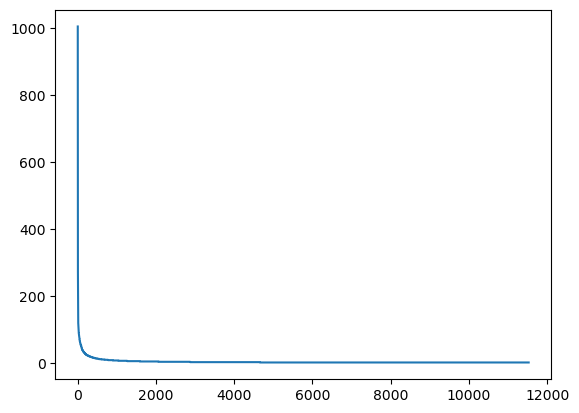

In [64]:
# plot the distribution of sorted document counts
# doc index on the x axis, count on the y
import matplotlib.pyplot as plt
plt.plot(sorted(top_documents.values(), reverse=True))

In [10]:
# What's does this Harrison document look like?
print(retriever.get_document_by_id('textbooks', 'InternalMed_Harrison_986'))

As average levels of health vary across regions and countries, so too do they vary within countries (Fig. 13e-4). Indeed, disparities within countries are often greater than those between high-income and low-income countries. For example, if lowand middle-income countries could reduce their overall childhood mortality rate to that of the richest one-fifth of their populations, global childhood mortality could be decreased by 40%. Disparities in health are mostly a result of social and economic factors such as daily living conditions, access to resources, and ability to participate in life-affecting decisions. In most countries, the health care sector actually tends to exacerbate health inequalities (the “inverse-care law”); because of neglect and discrimination, poor and marginalized communities are much less likely to benefit from public health services than those that are better off. Reforming health systems toward people-centered primary care provides an opportunity to reverse


In [ ]:
# Let's take the top N documents from our top document set and evaluate how well
# they improve the performance on a sample of questions. We will then select the
# document that improves the performance the most on our set.

from dataclasses import dataclass

NUM_SAMPLE_QUESTIONS = min(len(medqa), 50)
NUM_SAMPLE_DOCUMENTS = 10

@dataclass
class Document:
    id: str
    content: str


def evaluate_document(
    model: transformers.PreTrainedModel,
    tokenizer: transformers.PreTrainedTokenizer,
    doc: Document,
    df: pd.DataFrame,
):
    sample_questions = df.sample(NUM_SAMPLE_QUESTIONS, random_state=42).to_dict("records")
    results = batch_predict(model, tokenizer, sample_questions, context=[doc.content])
    for r in results:
        r["context"] = doc.id
    return pd.DataFrame(results)


def evaluate_documents(
    model: transformers.PreTrainedModel,
    tokenizer: transformers.PreTrainedTokenizer,
    docs: typing.List[Document],
    df: pd.DataFrame,
):
    # evaluate for each doc and concat the results into a single dataframe
    df = pd.concat(
        [evaluate_document(model, tokenizer, doc, df) for doc in tqdm.tqdm(docs)]
    )
    return df

top = sorted(top_documents.items(), key=lambda x: x[1], reverse=True)[
    :NUM_SAMPLE_DOCUMENTS
]
top = [
    Document(id=id, content=retriever.get_document_by_id("textbooks", id))
    for id, _ in top
]

combined = evaluate_documents(
    model,
    tokenizer,
    top,
    medqa,
)

In [72]:
combined.groupby('context').agg({'correct': 'mean'})

,correct
context,
InternalMed_Harrison_12,0.50
InternalMed_Harrison_1673,0.46
InternalMed_Harrison_1704,0.52
InternalMed_Harrison_19190,0.46
InternalMed_Harrison_201,0.50
InternalMed_Harrison_2763,0.48
InternalMed_Harrison_2955,0.50
InternalMed_Harrison_3641,0.46
InternalMed_Harrison_615,0.48


In [22]:
# so our best document gives ~0.49 on our sample, and our worst ~0.35. What's our naive result?
medqa_sample = medqa.sample(NUM_SAMPLE_QUESTIONS, random_state=42).to_dict("records")
naive = pd.DataFrame(batch_predict(model, tokenizer, medqa_sample))
naive

,output,dataset,question,options,reference,logits,probits,correct
0,D,medqa,An investigator is studying the frequency of p...,"{'A': '30%', 'B': '15%', 'C': '95%', 'D': '99%...",B,"[27.125, 27.25, 28.125, 27.125, 26.875]","[0.15082432, 0.17090634, 0.409983, 0.15082432,...",False
1,D,medqa,A 37-year-old woman presents to the occupation...,{'A': 'Type I–anaphylactic hypersensitivity re...,D,"[24.0, 23.5, 22.875, 34.0, 23.25]","[4.539498e-05, 2.7533446e-05, 1.4737591e-05, 0...",True
2,B,medqa,A 49-year-old man comes to the hospital for a ...,"{'A': 'Amylase of 200 U/L', 'B': 'Lymphocytosi...",E,"[29.0, 29.875, 28.75, 28.25, 29.0]","[0.17698982, 0.42457652, 0.13783981, 0.0836040...",False
3,D,medqa,An 8-year-old boy presents with a limp favorin...,"{'A': 'Slipped capital femoral epiphysis', 'B'...",D,"[30.875, 29.5, 27.75, 32.75, 26.75]","[0.12765265, 0.032275643, 0.0056086658, 0.8323...",True
4,B,medqa,A 12-year-old African American is exposed to p...,"{'A': 'IFN-gamma', 'B': 'IL-4', 'C': 'IL-17', ...",B,"[23.375, 34.5, 22.875, 20.875, 23.375]","[1.47386145e-05, 0.9999603, 8.939422e-06, 1.20...",True
5,E,medqa,A 76-year-old woman comes to the physician for...,"{'A': 'Increased lung compliance', 'B': 'Incre...",A,"[29.0, 29.625, 31.0, 28.375, 30.375]","[0.06780746, 0.12668101, 0.5010331, 0.03629472...",False
6,B,medqa,A 42-year-old woman comes to the physician for...,"{'A': 'Order a transthoracic echocardiogram', ...",D,"[29.125, 31.5, 31.125, 29.5, 28.25]","[0.047592025, 0.5116625, 0.35166016, 0.0692459...",False
7,E,medqa,A 35-year-old male nurse presents to the emerg...,"{'A': 'Dengue virus', 'B': 'Lymphocytic chorio...",E,"[28.375, 29.125, 31.125, 28.625, 31.375]","[0.024919514, 0.05275461, 0.3898068, 0.0319972...",True
8,C,medqa,A 5-year-old boy is brought to the emergency d...,"{'A': 'Diacylglycerol', 'B': 'Cyclic GMP', 'C'...",C,"[27.375, 26.5, 34.25, 23.875, 23.375]","[0.0010317353, 0.00043009128, 0.99848807, 3.11...",True
9,B,medqa,A 19-year-old college student is brought to th...,"{'A': 'Boerhaave syndrome', 'B': 'Mallory-Weis...",B,"[33.0, 34.0, 24.75, 22.0, 21.5]","[0.2689206, 0.731002, 7.025781e-05, 4.4914314e...",True


In [95]:
# where did our document hurt or help us vs the naive version?

best_results = combined[combined['context'] == 'InternalMed_Harrison_12'].reset_index(drop=True).sort_values(by='question')
naive_results = naive.sort_values(by='question')

for ((_, best_row), (_,naive_row)) in zip(best_results.iterrows(), naive_results.iterrows()):
  if best_row['correct'] == naive_row['correct']:
    continue
  if best_row['correct']:
    print('+', best_row['probits'] - naive_row['probits'], best_row['question'][:100])
  else:
    print('-', best_row['probits'] - naive_row['probits'], best_row['question'][:100])

- [-0.06589192  0.00268912  0.01601555  0.00663549  0.04055174] A 19-year-old nulligravid woman comes to the physician because of irregular heavy menstrual bleeding
+ [ 0.00318239  0.02664584  0.00916485  0.07712957 -0.11612266] A 25-year-old woman comes to the emergency department one hour after the sudden onset of diffuse abd
- [ 0.00077816  0.26460293 -0.25649005  0.00307769 -0.01196865] A 33-year-old man is brought to the emergency department 20 minutes after he fell from the roof of h
- [ 0.05930621  0.05129299  0.18535508  0.00694175 -0.30289602] A 52-year-old woman is accompanied by her husband to the emergency department with a severe occipita
+ [-0.23684973 -0.01055806  0.01146453  0.02322807  0.21271518] An 15-year-old boy is brought to the emergency department after he passed out in the hallway. On pre
- [ 6.2011462e-04 -8.0297589e-03  6.2527812e-01 -5.6853706e-01
 -4.9331389e-02] An otherwise healthy 16-year-old girl comes to the physician because she has not had a menstrua

In [10]:
# Let's build a training dataset based on our document and a sample of our training data.


def build_finetune_dataset(
    model: transformers.PreTrainedModel,
    tokenizer: transformers.PreTrainedTokenizer,
    retriever: medrag.utils.RetrievalSystem,
    training_set: pd.DataFrame,
    num_questions: int,
    docs_per_question: int,
):
    results = []
    sample_df = training_set.sample(num_questions, random_state=42)
    for _, record in tqdm.tqdm(sample_df.iterrows(), total=len(sample_df)):
        docs, scores = retriever.retrieve(record["question"], k=docs_per_question)
        naive_prediction = batch_predict(model, tokenizer, [record])[0]
        naive_probits = naive_prediction["probits"]
        predictions = batch_predict(
            model, tokenizer, [record], context=[doc["content"] for doc in docs]
        )

        for i, row in enumerate(predictions):
            doc_probits = row["probits"]
            diff_probits = doc_probits - naive_probits
            reference_idx = ord(row["reference"]) - ord("A")

            correct_diff = diff_probits[reference_idx]

            results.append(
                {
                    "question": row["question"],
                    "document": docs[i]["content"],
                    "reference": row["reference"],
                    "options": row["options"],
                    "diff": correct_diff,
                    "naive_answer": naive_prediction["answer"],
                    "naive_score": naive_probits[reference_idx],
                    "context_score": doc_probits[reference_idx],
                }
            )
    return pd.DataFrame(results)

if not pathlib.Path("./cache/embedding_ds.csv").exists():
    embedding_ds = build_finetune_dataset(
        model,
        tokenizer,
        retriever,
        medqa[medqa["split"] == "train"],
        num_questions=1000,
        docs_per_question=20,
    )
    embedding_ds.to_csv("./cache/embedding_ds.csv", index=False)
else:
    embedding_ds = pd.read_csv("./cache/embedding_ds.csv")

embedding_ds.sort_values(by="diff")

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

/home/user/mambaforge/envs/tensorml/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Dataset({
    features: ['sentence1', 'sentence2', 'label'],
    num_rows: 8192
})


Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine,Pearson Manhattan,Spearman Manhattan,Pearson Euclidean,Spearman Euclidean,Pearson Dot,Spearman Dot,Pearson Max,Spearman Max
200,No log,4.122073,-0.024736,-0.022323,-0.026001,-0.040640,-0.026840,-0.009170,-0.014260,-0.018472,-0.014260,-0.009170
400,No log,4.122063,-0.024399,-0.022323,-0.024522,-0.022323,-0.025535,-0.022323,-0.008420,-0.004954,-0.008420,-0.004954
600,4.199000,4.122064,-0.025142,-0.022323,-0.025130,-0.022323,-0.025955,-0.022323,0.024533,0.021026,0.024533,0.021026
800,4.199000,4.122063,-0.025496,-0.022421,-0.024824,-0.030123,-0.025540,-0.030124,-0.010070,-0.007111,-0.010070,-0.007111
1000,4.135000,4.122063,-0.024072,-0.023809,-0.024507,-0.023261,-0.025352,-0.023261,0.018180,0.015362,0.018180,0.015362
1200,4.135000,4.122063,-0.024936,-0.024144,-0.025731,-0.019280,-0.025573,-0.018983,-0.001216,-0.004849,-0.001216,-0.004849


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

KeyboardInterrupt: 

In [49]:
evaluator.show_progress_bar=True
evaluator(model)

Batches:   0%|          | 0/640 [00:00<?, ?it/s]

Batches:   0%|          | 0/640 [00:00<?, ?it/s]

{'pearson_cosine': -0.06810226225370059,
 'spearman_cosine': -0.05559002341330524,
 'pearson_manhattan': -0.06872582105690865,
 'spearman_manhattan': -0.06020936189466997,
 'pearson_euclidean': -0.06363380139335643,
 'spearman_euclidean': -0.05553909496020786,
 'pearson_dot': -0.07419404731340484,
 'spearman_dot': -0.07367379127064597,
 'pearson_max': -0.06363380139335643,
 'spearman_max': -0.05553909496020786}